 1. Setup: Install & Import

In [2]:
# Cell 2: Imports
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [4]:
# Cell 2: Imports and config
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from torchvision.datasets import VOCDetection
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.models.detection import ssd300_vgg16
from torch.utils.data import DataLoader
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 21
CKPT_DIR = "checkpoints"
OUT_DIR = "outputs"
os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

CLASS_NAMES = [
    "__background__", "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse",
    "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

transform = Compose([
    Resize((300, 300)),
    ToTensor(),
])

 2. Load & Prepare VOC Dataset

In [5]:

# Cell 3: Collate function for detection targets
def collate_fn(batch):
    images = []
    targets = []
    for img, t in batch:
        objs = t["annotation"]["object"]
        if not isinstance(objs, list): objs = [objs]
        boxes, labels = [], []
        for o in objs:
            bb = o["bndbox"]
            boxes.append([
                float(bb["xmin"]), float(bb["ymin"]),
                float(bb["xmax"]), float(bb["ymax"])
            ])
            labels.append(CLASS_NAMES.index(o["name"]))
        images.append(transform(img))
        targets.append({
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        })
    return images, targets



In [6]:
# Cell 4: Load Pascal VOC 2007 dataset
train_ds = VOCDetection("VOCdevkit/", year="2007", image_set="train", download=True)
val_ds   = VOCDetection("VOCdevkit/", year="2007", image_set="val", download=True)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)

 3. Define Model and Training Functions

In [7]:

# Cell 5: Model, optimizer, and helpers
model = ssd300_vgg16(weights=None, num_classes=NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=5e-4)

def save_ckpt(epoch):
    torch.save({
        "epoch": epoch,
        "model": model.state_dict(),
        "optim": optimizer.state_dict()
    }, os.path.join(CKPT_DIR, f"ssd_epoch_{epoch}.pth"))

def evaluate_loss(loader):
    model.train()
    total_loss = 0.0
    with torch.no_grad():
        for imgs, targets in loader:
            imgs = [i.to(DEVICE) for i in imgs]
            tgts = [{k: v.to(DEVICE) for k,v in t.items()} for t in targets]
            loss_dict = model(imgs, tgts)
            total_loss += sum(l for l in loss_dict.values()).item()
    return total_loss / len(loader)

def compute_map(loader):
    model.eval()
    metric = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.5])
    with torch.no_grad():
        for imgs, targets in loader:
            imgs = [img.to(DEVICE) for img in imgs]
            preds = model(imgs)
            preds_fmt = [
                {"boxes": p["boxes"].cpu(), "scores": p["scores"].cpu(), "labels": p["labels"].cpu()}
                for p in preds
            ]
            tgts_fmt = [
                {"boxes": t["boxes"].cpu(), "labels": t["labels"].cpu()}
                for t in targets
            ]
            metric.update(preds_fmt, tgts_fmt)
    res = metric.compute()
    return res["map_50"].item()

4. Train the Model

In [8]:

# Cell 6: Training loop
NUM_EPOCHS = 10
train_losses, val_losses, val_maps = [], [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for imgs, targets in train_loader:
        imgs = [i.to(DEVICE) for i in imgs]
        tgts = [{k: v.to(DEVICE) for k,v in t.items()} for t in targets]
        loss_dict = model(imgs, tgts)
        loss = sum(l for l in loss_dict.values())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    val_loss = evaluate_loss(val_loader)
    map50 = compute_map(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_maps.append(map50)

    print(f"Epoch {epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, mAP@0.5={map50:.4f}")
    save_ckpt(epoch)

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


Epoch 0: train_loss=19.0223, val_loss=18.2923, mAP@0.5=0.0000
Epoch 1: train_loss=18.2769, val_loss=18.0501, mAP@0.5=0.0000
Epoch 2: train_loss=18.1441, val_loss=17.8096, mAP@0.5=0.0000
Epoch 3: train_loss=17.8730, val_loss=17.5474, mAP@0.5=0.0000
Epoch 4: train_loss=17.5652, val_loss=17.1839, mAP@0.5=0.0000
Epoch 5: train_loss=17.0001, val_loss=16.5327, mAP@0.5=0.0000
Epoch 6: train_loss=15.8661, val_loss=14.5775, mAP@0.5=0.0000
Epoch 7: train_loss=13.3863, val_loss=12.2678, mAP@0.5=0.0001
Epoch 8: train_loss=11.8187, val_loss=11.3091, mAP@0.5=0.0002
Epoch 9: train_loss=10.9574, val_loss=10.6990, mAP@0.5=0.0001


In [13]:
torch.save({
    "epoch": NUM_EPOCHS - 1, # Save the last epoch number
    "model": model.state_dict(),
    "optim": optimizer.state_dict()
}, os.path.join(CKPT_DIR, "ssd_final.pth"))

5. Plot Loss & mAP Curves

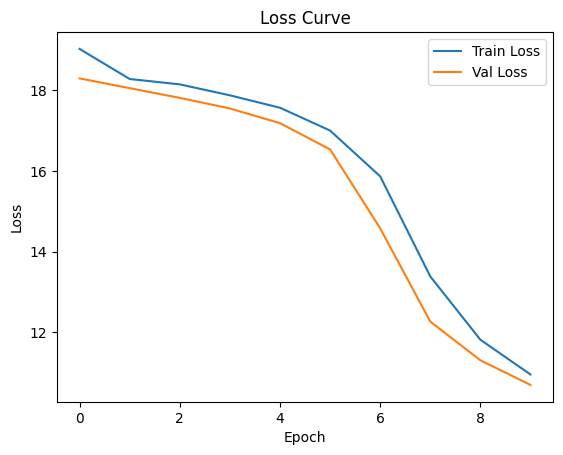

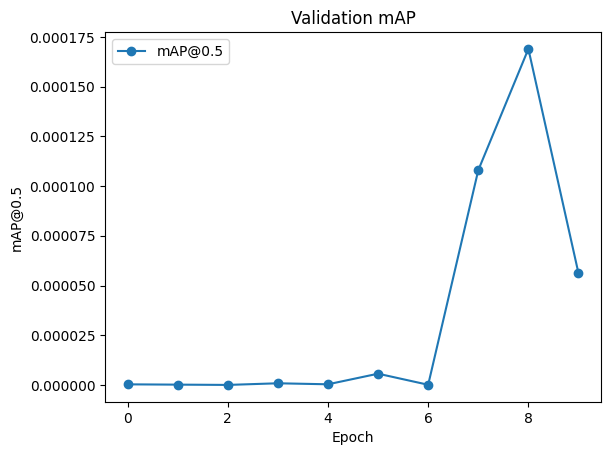

In [9]:

# Cell 7: Plot and save curves
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss Curve")
plt.savefig(os.path.join(OUT_DIR, "loss_curve.png"))

plt.figure()
plt.plot(val_maps, marker='o', label="mAP@0.5")
plt.xlabel("Epoch"); plt.ylabel("mAP@0.5"); plt.legend(); plt.title("Validation mAP")
plt.savefig(os.path.join(OUT_DIR, "map_curve.png"))

6. Inference on Sample Image

In [15]:

# Cell 8: Upload and predict
from google.colab import files
uploaded = files.upload()

# Use the first uploaded image
img_name = list(uploaded.keys())[0]
img_path = f"./{img_name}"

# Run inference
model.eval()
img = Image.open(img_path).convert("RGB")
inp = transform(img).unsqueeze(0).to(DEVICE)
with torch.no_grad():
    pred = model(inp)[0]

draw = ImageDraw.Draw(img)
for box, score, label in zip(pred["boxes"], pred["scores"], pred["labels"]):
    if score < 0.5: continue
    x0, y0, x1, y1 = box.cpu().tolist()
    draw.rectangle([x0, y0, x1, y1], outline="red", width=2)
    draw.text((x0, y0), f"{CLASS_NAMES[label]} {score:.2f}", fill="red")

result_path = os.path.join(OUT_DIR, "example_result.jpg")
img.save(result_path)
img.show()

Saving 007072.jpg to 007072 (1).jpg


In [20]:
#!/usr/bin/env python
"""
inference.py

Loads checkpoints/ssd_final.pth, runs inference on all images in test_images/,
and writes annotated outputs to outputs/, correctly rescaling boxes.
"""

import os, torch
from PIL import Image, ImageDraw
from torchvision.transforms import Compose, Resize, ToTensor
from torchvision.models.detection import ssd300_vgg16

# Config
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CKPT_PATH   = "checkpoints/ssd_final.pth"
TEST_DIR    = "test_images"
OUT_DIR     = "outputs"
CONF_THRESH = 0.5

# VOC class names
CLASS_NAMES = [
    "__background__", "aeroplane", "bicycle", "bird", "boat",
    "bottle", "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

os.makedirs(OUT_DIR, exist_ok=True)

# Load model
model = ssd300_vgg16(weights=None, num_classes=21).to(DEVICE)

# Load the checkpoint dictionary
checkpoint = torch.load(CKPT_PATH, map_location=DEVICE)

# Extract the model's state_dict and load it
model.load_state_dict(checkpoint["model"])

model.eval()

# Build the same transform used at training
transform = Compose([ Resize((300, 300)), ToTensor() ])

for fname in os.listdir(TEST_DIR):
    if not fname.lower().endswith((".jpg","jpeg","png")):
        continue

    img_path = os.path.join(TEST_DIR, fname)
    orig = Image.open(img_path).convert("RGB")
    orig_w, orig_h = orig.size

    # Run through model
    inp = transform(orig).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        pred = model(inp)[0]

    # Draw predictions, rescaling box coords back to original size
    draw = ImageDraw.Draw(orig)
    scale_x, scale_y = orig_w / 300, orig_h / 300

    for box, score, label in zip(pred["boxes"], pred["scores"], pred["labels"]):
        if score < CONF_THRESH:
            continue
        x0, y0, x1, y1 = box.cpu().tolist()
        # rescale
        x0, y0, x1, y1 = x0*scale_x, y0*scale_y, x1*scale_x, y1*scale_y
        draw.rectangle([x0, y0, x1, y1], outline="red", width=2)
        draw.text((x0, y0), f"{CLASS_NAMES[label]} {score:.2f}", fill="red")

    out_path = os.path.join(OUT_DIR, fname)
    orig.save(out_path)
    print(f"[✓] Saved annotated image: {out_path}")

[✓] Saved annotated image: outputs/007072.jpg
[✓] Saved annotated image: outputs/009940.jpg
[✓] Saved annotated image: outputs/008051.jpg
[✓] Saved annotated image: outputs/005740.jpg


In [ ]:
write code to